# Anna's code to calculate thermal fractions

In [6]:
###PURPOSE: calculate thermal fractions based on results from MCMC fitting

#############################################################################################

#import statements
import numpy as np
from astropy.io import ascii
from astropy.table import Table, Column
from astropy import units as u
from astropy import constants as c
from astropy.stats import median_absolute_deviation
import h5py
import sys
import pandas as pd

#############################################################################################

#define functions for calculating different emission components

#Planck function (used in I_dust)
def B_nu(nu, T):
    np.seterr(over='ignore')
    return 2.0*c.h*(nu**3)/(c.c**2*(np.expm1(c.h*nu/(c.k_B*T))))

#thermal dust emission
def I_dust(nu, Td, beta, Ad):
    return Ad*(nu/(353.*u.GHz))**beta*B_nu(nu,Td)/B_nu(353*u.GHz,Td)

#free free emission
def I_ff(nu, T, Aff):
    def gff(nu, T):
        T4 = T/(1.e4*u.K)
        nu9 = nu/(1.*u.GHz)
        gnu = np.log(np.exp(5.960 - (np.sqrt(3.)/np.pi)*np.log(nu9*(T4**(-3./2.)))) + np.exp(1.))
        return gnu   
    
    return Aff*gff(nu,T)/gff(30.*u.GHz,T)

#synchrotron emission
def I_sync(nu, alpha, As):
    return As*(nu/(30.*u.GHz))**alpha

#############################################################################################

#read in results from MCMC fitting
results=pd.read_csv('/lustre/cv/students/adignan/data/mcmcresults/results_mcmc_round2.csv')
sources=['NGC2146a','NGC2146b','NGC2146c']
results=results[results['Source ID'].isin(sources)]

results = Table.from_pandas(results)

#initialize empty lists
medians=[] #medians of calculated thermal fractions for ALL models
mads=[] #scaled MADs of of calculated thermal fractions for ALL models
stds=[] #standard deviations of calculated thermal fractions for ALL models
median_errs=[] #errors on the medians of calculated thermal fractions for ALL models

vals_50=[] #value at the 50th percentile
vals_84=[] #value at the 84th percentile
vals_16=[] #value at the 16th pecentile

#############################################################################################

#for loop to calculate thermal fractions and uncertainties
for row in results:

    file=row['Source ID']
    alpha=row['alpha median']
    As=row['A_s median']
    Aff=row['A_ff median']
    Ad=row['A_d median']
    print('Working on ' + str(file))

    #read in MCMC file
    (nu, fnu, sfnu) = np.genfromtxt('/lustre/cv/students/adignan/data/mcmcfiles/'+file, unpack=True)

    #read in samples file
    hf = h5py.File('/lustre/cv/students/adignan/data/hdf5_round2/'+str(file)+'_round2-samples.h5', 'r')
    n1 = hf.get('dataset')
    n1=np.array(n1)

    #initialize empty list for saving thermal fractions based on ALL models
    tfrac=[]

    #calculate thermal fraction for ALL models, not just best-fit one
    for row in n1:
        sync=I_sync(33*u.GHz, row[0], row[1])
        ff=I_ff(33*u.GHz, 1.e4*u.K, row[3])
        dust=I_dust(33*u.GHz, 20.*u.K, 1.50, row[2])
        total=sync+ff+dust
        tfrac.append(ff/total)

    hf2 = h5py.File('/lustre/cv/students/adignan/data/tfracs/'+str(file)+'-tfracs.h5', 'w')
    hf2.create_dataset('dataset', data=tfrac)
    hf2.close

    #calculate thermal fraction based on best-fit result
    sync_best=I_sync(33*u.GHz, alpha, As)
    ff_best=I_ff(33*u.GHz, 1.e4*u.K, Aff)
    dust_best=I_dust(33*u.GHz, 20.*u.K, 1.50, Ad)

    total_best=sync_best+ff_best+dust_best

    #calculate a few different stats for the samples

    #append median of calculated thermal fractions of ALL models to final list
    medians.append(np.median(tfrac)) 
    #append error on the median (calculated above) to final list
    median_errs.append(np.std(tfrac)/np.sqrt(len(n1)))
    #append scaled MAD of calculated thermal fractions of ALL models to final list
    mads.append(median_absolute_deviation(tfrac)/0.6745)
    #append standard deviations of calculated thermal fracs of ALL models to final list
    stds.append(np.std(tfrac))
    #append different percentile values of ALL calculated thermal fracs to final list
    percentiles=np.percentile(tfrac,[16,50,84],axis=0)
    vals_50.append(percentiles[1])
    vals_84.append(percentiles[2]-percentiles[1])
    vals_16.append(percentiles[1]-percentiles[0])

    #close hdf5 file so it doesn't complain
    hf.close

#make astropy Columns
idscol=Column(results['Source ID'],name='source ID')
medianscol=Column(medians,name='median tf')
madscol=Column(mads,name='scaled MAD')
stdscol=Column(stds,name='STD')
median_errscol=Column(median_errs,name='error on median tf')

vals_50col=Column(vals_50,name='median tf (percentile)')
vals_84col=Column(vals_84,name='84th – median')
vals_16col=Column(vals_16,name='median – 16th')

#make astropy Table of results
tbl=Table([idscol,medianscol,madscol,stdscol,median_errscol,
          vals_50col,vals_84col,vals_16col])

#write results to csv file
tbl.write('/users/adignan/thermalfractions_ngc2146.csv',format='csv',overwrite=True)

Working on NGC2146b
Working on NGC2146a
Working on NGC2146c


# Eric's code

In [8]:
import h5py
import numpy as np
from astropy import units as u

def I_ff(nu, T, Aff):
    def gff(nu, T):
        T4 = T/(1.e4*u.K)
        nu9 = nu/(1.*u.GHz)
        gnu = np.log(np.exp(5.960 - (np.sqrt(3.)/np.pi)*np.log(nu9*(T4**(-3./2.)))) + np.exp(1.))
        return gnu   
    
    return Aff*gff(nu,T)/gff(30.*u.GHz,T)

(nu, fnu, sfnu) = np.genfromtxt('/users/adignan/mcmcfiles/NGC0337a', unpack=True)

hf = h5py.File('/users/adignan/hdf5/NGC0337a-samples_eric.h5', 'r')
hf.keys()
samp = hf.get('dataset')
samp = np.array(samp)
samp.shape
hf.close

fnu33_ff_allfits = []

for i in samp[:,3]:
    Aff_fit = i
    tmp = I_ff(33*u.GHz, 1.e4*u.K, Aff_fit)
    fnu33_ff_allfits.append(tmp)
#     fnu33_ff_allfits = I_ff(33*u.GHz, 1.e4*u.K, Aff_fit)

Aff_mcmc=0.2860688550537509

#report: median; error on median, dispersion
# <x>, (pi/2)*mad(x)/sqrt(N), mad(x)
from astropy.stats import median_absolute_deviation as mad
fnu33 = fnu[2]
efnu33 = sfnu[2]
#fnu33_fit = np.interp(33*u.GHz, nu_out, snu_model)*u.mJy #f33 from best fit
fnu33_ff_fit = I_ff(33*u.GHz, 1.e4*u.K, Aff_mcmc) #f33^T from best fit
fnu33_ff_fit2 = np.median(fnu33_ff_allfits) #median of f33^T from all fits
efnu33_ff_fit_med = (np.pi/2)*np.std(fnu33_ff_allfits)/np.sqrt(len(fnu33_ff_allfits)) #error on median
efnu33_ff_fit = mad(fnu33_ff_allfits)/0.6745 #Scaled MAD f33^T from all fits
efnu33_ff_fit2 = np.std(fnu33_ff_allfits) #rms f33^T from all fits#print(fnu33_ff_fit, fnu33_ff_fit2)
#print(efnu33_ff_fit_med)
# print(efnu33_ff_fit, efnu33_ff_fit2)
tf33 = fnu33_ff_fit/fnu33 #33 GHz ff fracion
etf33 = np.sqrt((efnu33_ff_fit2/fnu33_ff_fit)**2 + (efnu33/fnu33)**2)*tf33
print(tf33.value, etf33.value)

0.4672513457488573 0.3531428093872606


# Making histograms of results

0.21577705564713323
0.006479741245353672
0.9797194004725066


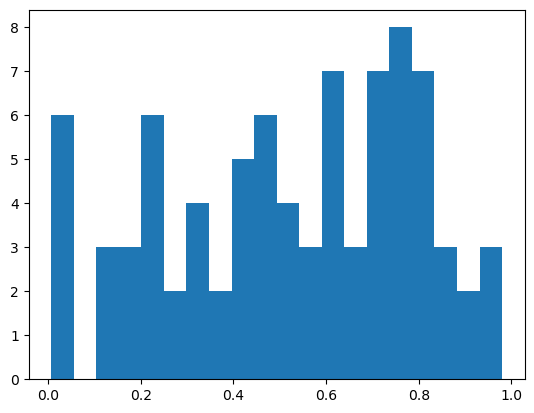

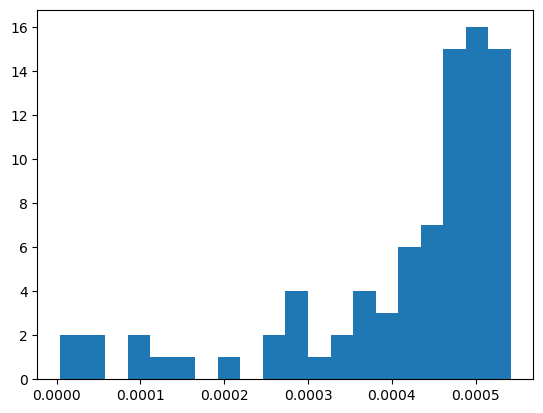

In [53]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(tbl['median tf'],bins=20)
plt.figure()
plt.hist(tbl['error on median tf'],bins=20)

print(median_absolute_deviation(tbl['median tf']))
print(np.min(tbl['median tf']))
print(np.max(tbl['median tf']))